# Setup

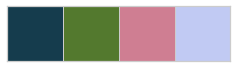

In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import pickle
import joblib
from __future__ import division
from IPython.display import display
from itertools import product

# set styling for plots
%matplotlib inline  
sns.set(style = "whitegrid")
sns.set_palette('cubehelix',4)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
sns.palplot(sns.color_palette())

# define names of models
clfs = ["LogitNonLinear","RandomForestIsotonic"]
outnames = {clfs[0]: "Nonlinear Logit",clfs[1]: "Random Forest","Difference" : "Difference"}

# set race categories for plots
plotrace = ["Asian","White Non-Hispanic","White Hispanic","Black"]

In [2]:
# parameters 
params = {'av_premium': 0.3, 'loss_prop_to' : 'ltv', 'gamma': 1, 'delta' : 0.75, 'phi' : 0.1,
         'sda_adjusted' : True, 'bias' : 0.411}

# sda parameters
sda_params = {'high': 0.006, 'high_start': 30, 'high_end': 60,
                'low' : 0.0003, 'low_start': 120, 'measured_cumulative' : 36, 'T' : 360}

# Setup utilities and solution algorithm

In [3]:
# bias correction
def adjust(p,b,base_index,epsilon = 0.0001):
    t = np.log(-np.log(1-p)+epsilon).values
    tbase = t[:,base_index].reshape(-1,1)
    newt = b * tbase + (1-b) * t
    newp = 1- np.exp(epsilon - np.exp(newt))
    return newp

# sda adjustment
def sda(p,sda_params):
    T = sda_params["T"]
    hmax = sda_params["high"]
    hmin = sda_params["low"]
    t1 = sda_params["high_start"]
    t2 = sda_params["high_end"]
    t3 = sda_params["low_start"]
    t_hat = sda_params["measured_cumulative"]
    H = hmin * (2*T - t2 - t3) / 2 + hmax * (t2 + t3 - t1) / 2
    log_survival_adjustment = H / (hmax*(t_hat - 0.5*t1))
    log_survival = np.log(1-p) * log_survival_adjustment
    newp = 1- np.exp(log_survival)
    return newp

# bins for logit prediction
def mkbins(df):
    bins = pd.DataFrame(index = df.index)

    fico_cuts = [0] + list(range(280,870,20))
    fico_bin = pd.cut(df["fico_orig_fill"], fico_cuts, labels = fico_cuts[0:-1], right = False).fillna(0)
    fico_bin.loc[(fico_bin>0) & (fico_bin < 600),] = 600
    fico_bin.loc[fico_bin==840,] = 820
#     fico_bin = fico_bin.cat.remove_unused_categories()

    ltv_cuts = list(range(20,110,5))
    ltv_bin = pd.cut(df["ltv_ratio_fill"], ltv_cuts, labels = ltv_cuts[0:-1], right = False)
    ltv_80 = (df["ltv_ratio_fill"]==80).astype(int)    

    inc_cuts = list(range(-25,550,25))
    income_bin = pd.cut(df["applicant_income"],inc_cuts, labels = inc_cuts[0:-1],right = False)

    bins = bins.join(pd.get_dummies(fico_bin, prefix = "fico_bin_dum"))
    bins = bins.join(pd.get_dummies(income_bin, prefix = "income_bin_dum"))
    bins = bins.join(pd.get_dummies(ltv_bin, prefix = "ltv_bin_dum"))
    bins["ltv_80_dum_0"] = 1 - ltv_80
    bins['const'] = 1
    return bins

# predict on grid
def predict(df,clfs,models,features,sato):
    dfc = df.copy()
    grid = {}
    for name in clfs:
        grid[name] = pd.DataFrame(index=dfc.index,columns = sato)
        for s in sato:
            print(name + ', ' + str(s))
            dfc["sato"] = s
            if name.startswith('Logit'): 
                    grid[name][s] = models[name].predict(dfc[features[name]]) 
            else:
                    grid[name][s] = models[name].predict_proba(dfc[features[name]])[:,1]
    return grid

In [4]:
def eqsolve(df,grid,sato,params,sda_params,draw=False):
    # setup for npv
    base_index = np.argmin(abs(sato))
    base = (df["cur_int_rate"] - df["sato"]).values.reshape(-1,1) 
    wacc = (100 + base - params['av_premium']) / 100
    repayment = (100 + base + sato) / 100
    recovery = 100 * params["delta"] * params["gamma"] / df["ltv_ratio_fill"].values.reshape(-1,1)
    recovery = np.minimum(recovery,repayment) - params["phi"] 

    # equilibrium computation
    eq = pd.DataFrame(index = df.index, columns = clfs)
    grida = {}
    P = {}
    npv = {}
    nplot = 20
    if draw: fig,ax = plt.subplots(1,len(clfs),figsize = (12,6),sharex=True,sharey=True)
    for i,name in enumerate(clfs):
        grida[name] = adjust(grid[name],params['bias'],base_index)
        P[name] = sda(grida[name],sda_params)
        npv[name] = (1-P[name]) * repayment + P[name] * recovery - wacc
        pos = (npv[name]>0)

        # test: all NPV vectors should start negative, otherwise WACC is too low 
        if np.any(pos[:,0]):
            ix = np.argmax(pos[:,0])
            raise ValueError('NPV in row %d starts positive, adjust parameters' % ix)

        # find smallest positive element with argmax -- if this returns 0, then reject
        ix = np.argmax(pos,axis=1)
        accept = ix>0

        # linear interpolation for solution
        n0 = npv[name][accept,ix[accept]-1]; n1 = npv[name][accept,ix[accept]]
        s0 = sato[ix[accept]-1]; s1 = sato[ix[accept]]
        slope = (n1 - n0) / (s1 - s0)
        sol = s0 - n0 / slope

        eq[name].iloc[accept] = sol

        # illustration
        if draw:
            ax[i].plot(sato,npv[name][0:nplot,:].T,'--o',alpha = 0.5)
            nacc = accept[0:nplot].sum()
            ax[i].plot(sol[0:nacc],np.zeros(nacc),'ok',markersize = 10)
            ax[i].plot(sato,np.zeros(sato.shape[0]))
            ax[i].set_ylabel('NPV, Bias = %.2f' % params['bias'])
            ax[i].set_title(name)
            ax[i].set_xlabel('sato')
            sns.distplot(sol,ax = ax[i].twinx()).set(yticks=[])

    if draw: plt.savefig(path2 + 'fig_eqm_illustration.pdf')
    return eq

# Load and clean data

In [5]:
# set paths to saved data
path = '../../data/'

# data
df = pd.read_csv(path + 'all_vals_race0_interestrate1.csv')
race = pd.read_csv(path + 'race_clean.csv',index_col=0); df["Race"] = race["Race"]


# take random sample
df = df.sample(n=10000,random_state=2)
race = df["Race"]
race[~race.isin(plotrace)] = "Other"
minority = (race == "Black")| (race == "White Hispanic")

# make bins for logit prediction
bins = mkbins(df)
df = df.join(bins)




/Users/psg24/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
<ipython-input-5-a951d83ddf97>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race[~race.isin(plotrace)] = "Other"


In [6]:

path2 = '../../output/'
# saved classifiers
models = {}; features = {}
for name in clfs:
    if name.startswith('Logit'):
        models[name] = pickle.load(open(path2 + name + "_race0_interestrate1.pkl",'rb'))
        features[name] = list(models[name].params.index)
    else:
        models[name] = joblib.load(open(path2 + name + "_race0_interestrate1.pkl",'rb'))
        features[name] = [x.lower() for x in list(pd.read_csv(path + 'feature_names_norace' + name + '.csv').columns)]

# Table VII:  Equilibrium outcomes

LogitNonLinear, -0.7
LogitNonLinear, -0.6
LogitNonLinear, -0.5
LogitNonLinear, -0.4
LogitNonLinear, -0.30000000000000004
LogitNonLinear, -0.20000000000000007
LogitNonLinear, -0.10000000000000009
LogitNonLinear, -1.1102230246251565e-16
LogitNonLinear, 0.09999999999999987
LogitNonLinear, 0.19999999999999984
LogitNonLinear, 0.2999999999999998
LogitNonLinear, 0.3999999999999997
LogitNonLinear, 0.4999999999999998
LogitNonLinear, 0.5999999999999999
LogitNonLinear, 0.6999999999999997
LogitNonLinear, 0.7999999999999996
LogitNonLinear, 0.8999999999999997
LogitNonLinear, 0.9999999999999998
LogitNonLinear, 1.0999999999999996
LogitNonLinear, 1.1999999999999995
LogitNonLinear, 1.2999999999999996
LogitNonLinear, 1.3999999999999997
LogitNonLinear, 1.4999999999999993
RandomForestIsotonic, -0.7


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


RandomForestIsotonic, -0.6
RandomForestIsotonic, -0.5
RandomForestIsotonic, -0.4
RandomForestIsotonic, -0.30000000000000004
RandomForestIsotonic, -0.20000000000000007
RandomForestIsotonic, -0.10000000000000009
RandomForestIsotonic, -1.1102230246251565e-16
RandomForestIsotonic, 0.09999999999999987


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


RandomForestIsotonic, 0.19999999999999984
RandomForestIsotonic, 0.2999999999999998
RandomForestIsotonic, 0.3999999999999997
RandomForestIsotonic, 0.4999999999999998
RandomForestIsotonic, 0.5999999999999999
RandomForestIsotonic, 0.6999999999999997
RandomForestIsotonic, 0.7999999999999996
RandomForestIsotonic, 0.8999999999999997
RandomForestIsotonic, 0.9999999999999998


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


RandomForestIsotonic, 1.0999999999999996
RandomForestIsotonic, 1.1999999999999995
RandomForestIsotonic, 1.2999999999999996
RandomForestIsotonic, 1.3999999999999997
RandomForestIsotonic, 1.4999999999999993


/Users/psg24/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/psg24/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/psg24/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

Accept        Mean SATO        SD SATO       
                       NL     RF        NL     RF      NL     RF
Race                                                            
Asian               100.0  100.0     0.191  0.185   0.305  0.292
White Non-Hispanic  100.0  100.0     0.187  0.187   0.296  0.294
White Hispanic      100.0  100.0     0.237  0.242   0.327  0.334
Black               100.0  100.0     0.182  0.182   0.294  0.296
Other               100.0  100.0     0.195  0.195   0.300  0.297
Population          100.0  100.0     0.192  0.192   0.299  0.296
Cross-group SD        0.0    0.0     0.008  0.008     NaN    NaN

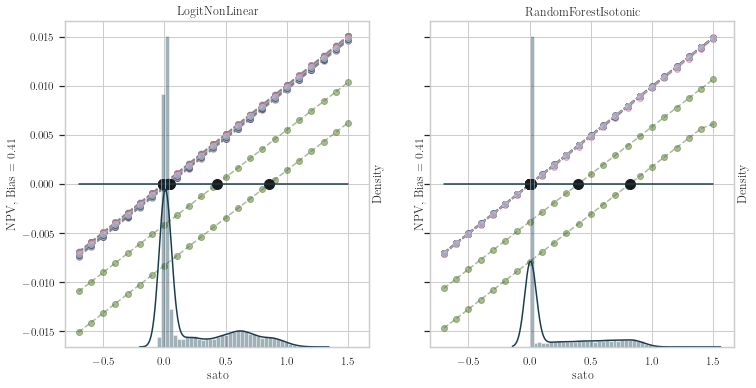

In [7]:
sato = np.arange(-0.7,1.6,0.1) # wider for roubstness

#fix for simulated code
#dropList = ['prop_state_dum_HI', 'prop_state_dum_ME', 'prop_state_dum_CA', 'loan_type_mcdash_dum_C', 'prop_state_dum_CO', 'prop_state_dum_MD', 'jumbo_flg_dum_N', 'prop_state_dum_KS', 'prop_state_dum_MA', 'prop_state_dum_RI', 'prop_state_dum_VT', 'prop_state_dum_SC', 'prop_state_dum_OR', 'prop_state_dum_OK', 'prop_state_dum_DC', 'prop_state_dum_GA', 'prop_state_dum_PA', 'prop_state_dum_NY', 'prop_state_dum_OH', 'prop_state_dum_UT', 'prop_state_dum_DE', 'prop_state_dum_MT', 'prop_state_dum_NH', 'prop_state_dum_WI', 'prop_state_dum_IA', 'prop_state_dum_SD', 'prop_state_dum_AR', 'prop_state_dum_LA', 'prop_state_dum_IL', 'prop_state_dum_MN', 'prop_state_dum_MO', 'prop_state_dum_NC', 'prop_state_dum_TN', 'prop_state_dum_AL', 'prop_state_dum_AZ', 'prop_state_dum_TX', 'prop_state_dum_ID', 'prop_state_dum_NM', 'prop_state_dum_AK', 'prop_state_dum_WA', 'prop_state_dum_WV', 'prop_state_dum_IN', 'prop_state_dum_FL', 'prop_state_dum_CT', 'prop_state_dum_NV', 'prop_state_dum_MI', 'prop_state_dum_NE', 'prop_state_dum_NJ', 'prop_state_dum_KY', 'prop_state_dum_VA', 'prop_state_dum_MS', 'prop_state_dum_ND']
#tempList = set(features["RandomForestIsotonic"])
#tempList.difference_update(dropList)
#print(list(tempList))
#features["RandomForestIsotonic"] = list(tempList)

grid = predict(df,clfs,models,features,sato)
eq = eqsolve(df,grid,sato,params,sda_params,draw=True)
eq = eq.astype('float')

def frac_notna(x):
    f = 100*(x.count() / x.shape[0])
    return f

stats = {}

tabrace = plotrace + ["Other"]

accept = eq.groupby(race).agg(frac_notna).loc[tabrace]
cross_accept = eq.groupby(race).transform(frac_notna).std().rename("Cross-group SD")
pop_accept = pd.Series(eq.apply(frac_notna),name = "Population")
stats["Accept"] = accept.append(pop_accept).append(cross_accept)

eqrate = eq.groupby(race).mean()
cross_eqrate = eq.groupby(race).transform('mean').std().rename("Cross-group SD")
pop_eqrate = pd.Series(eq.mean(),name = "Population")
stats["Mean SATO"] = eqrate.append(pop_eqrate).append(cross_eqrate)

sdrate = eq.groupby(race).std()
pop_sdrate = pd.Series(eq.std(),name = "Population")
stats["SD SATO"] = sdrate.append(pop_sdrate)


stats = pd.concat(stats,axis=1,sort=False).round(3).rename(columns = {clfs[0]:'NL',clfs[1]:'RF'})
display(stats)